In [1]:
import gzip
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import sklearn
import string
from collections import defaultdict
from gensim.models import Word2Vec
#from nltk.stem.porter import *
from sklearn import linear_model
from sklearn.manifold import TSNE
import pandas as pd
import gzip
from collections import defaultdict
from sklearn import linear_model
import csv
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
def parse(f):
    for l in gzip.open(f, 'r'):
        yield eval(l)

In [3]:
null = None
rent = list(parse("renttherunway_final_data.json.gz"))

In [4]:
cloth = pd.DataFrame(rent)
cloth.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016"


## Cleaning

In [5]:
for col in cloth.columns:
    if cloth[col].isna().sum() != 0:
        print(col, cloth[col].isna().sum())

bust size 18411
weight 29982
rating 82
rented for 10
body type 14637
height 677
age 960


In [6]:
unique_weights = [x for x in cloth['weight'].unique() if isinstance(x, str)]
unique_heights = [x for x in cloth['height'].unique() if isinstance(x, str)]

def weight_converter(x):
    if isinstance(x, float):
        chosen = random.randint(0, len(unique_weights) - 1)
        x = unique_weights[chosen]
    return int(x.strip('lbs'))

def height_converter(x):
    if isinstance(x, float):
        chosen = random.sample(unique_heights, 1)[0]
        x = chosen
    nums = x.split()
    num1 = int(re.findall(r'\d+', nums[0])[0])
    num2 = int(re.findall(r'\d+', nums[-1])[0])
    return (12 * num1) + num2

bust_size = [x for x in list(cloth['bust size'].unique()) if isinstance(x, str)]
def bust_size_imputer(x):
    if isinstance(x, float):
        return random.sample(bust_size, 1)[0]
    return x

body_type = [x for x in list(cloth['body type'].unique()) if isinstance(x, str)]
def body_type_imputer(x):
    if isinstance(x, float):
        return random.sample(body_type, 1)[0]
    return x

ratings = [x for x in list(cloth['rating'].unique()) if isinstance(x, str)]
def rating_imputer(x):
    if (isinstance(x, float)) or (x == None):
        return int(random.sample(ratings, 1)[0])
    return int(x)

rented = [x for x in list(cloth['rented for'].unique()) if isinstance(x, str)]
def rent_imputer(x):
    if isinstance(x, float):
        return random.sample(body_type, 1)[0]
    return x

age = [x for x in list(cloth['age'].unique()) if isinstance(x, str)]
def age_imputer(x):
    if isinstance(x, float):
        return int(random.sample(age, 1)[0])
    return int(x)

In [7]:
cloth['weight'] = cloth['weight'].copy().apply(weight_converter)
cloth['height'] = cloth['height'].copy().apply(height_converter)
cloth['bust size'] = cloth['bust size'].copy().apply(bust_size_imputer)
cloth['body type'] = cloth['body type'].copy().apply(body_type_imputer)
cloth['rating'] = cloth['rating'].copy().apply(rating_imputer)
cloth['rented for'] = cloth['rented for'].copy().apply(rent_imputer)
cloth['age'] = cloth['age'].copy().apply(age_imputer)

In [8]:
cloth.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68,14,28,"April 20, 2016"
1,fit,273551,34b,153475,132,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66,12,36,"June 18, 2013"
2,fit,360448,34d,1063761,103,10,party,This hugged in all the right places! It was a ...,apple,It was a great time to celebrate the (almost) ...,sheath,64,4,116,"December 14, 2015"
3,fit,909926,34c,126335,135,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65,8,34,"February 12, 2014"
4,fit,151944,34b,616682,145,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69,12,27,"September 26, 2016"


## EDA

In [9]:
import seaborn as sns
sns.set_theme(style="whitegrid")

(array([  134.,   321., 12264., 37560., 52385., 66153., 18473.,  4981.,
          204.,    69.]),
 array([54. , 56.4, 58.8, 61.2, 63.6, 66. , 68.4, 70.8, 73.2, 75.6, 78. ]),
 <BarContainer object of 10 artists>)

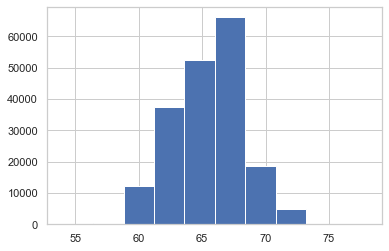

In [10]:
plt.hist(cloth['height'])

(array([  479.,  3383., 44951., 84366., 34038., 11055.,  6168.,  4351.,
         2542.,  1211.]),
 array([ 50.,  75., 100., 125., 150., 175., 200., 225., 250., 275., 300.]),
 <BarContainer object of 10 artists>)

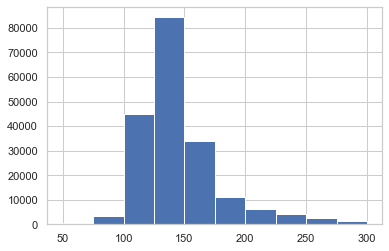

In [11]:
plt.hist(cloth['weight'])

(array([46986., 44577., 59337., 20373., 14934.,  1809.,  2469.,  1112.,
          640.,   307.]),
 array([ 0. ,  5.8, 11.6, 17.4, 23.2, 29. , 34.8, 40.6, 46.4, 52.2, 58. ]),
 <BarContainer object of 10 artists>)

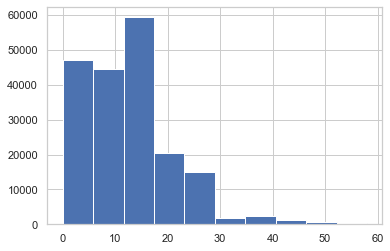

In [12]:
plt.hist(cloth['size'])

(array([1.58000e+02, 8.14600e+03, 1.23552e+05, 4.44590e+04, 1.36410e+04,
        2.17500e+03, 1.49000e+02, 8.00000e+01, 3.50000e+01, 1.49000e+02]),
 array([  0. ,  11.7,  23.4,  35.1,  46.8,  58.5,  70.2,  81.9,  93.6,
        105.3, 117. ]),
 <BarContainer object of 10 artists>)

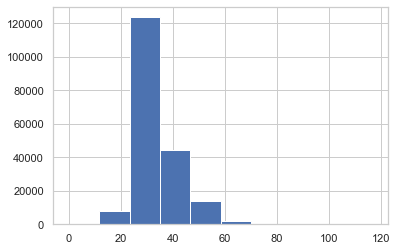

In [13]:
plt.hist(cloth['age'])

In [14]:
rand = cloth.sample(10000)

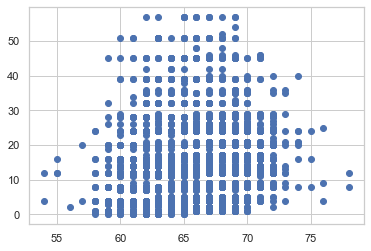

In [15]:
plt.scatter(rand['height'], rand['size'])

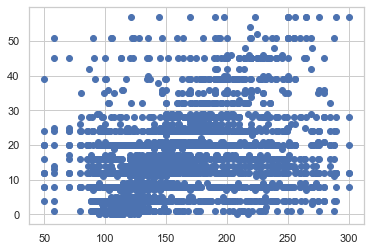

In [16]:
plt.scatter(rand['weight'], rand['size'])

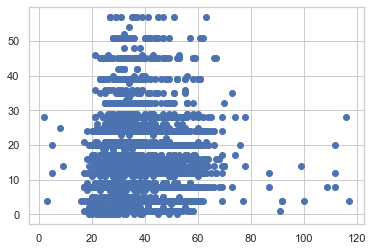

In [17]:
plt.scatter(rand['age'], rand['size'])

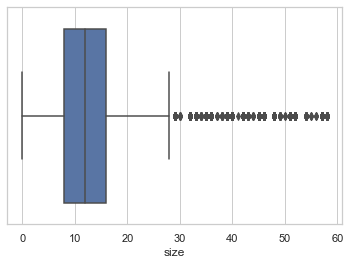

In [18]:
ax = sns.boxplot(x=cloth["size"])

<AxesSubplot:xlabel='age'>

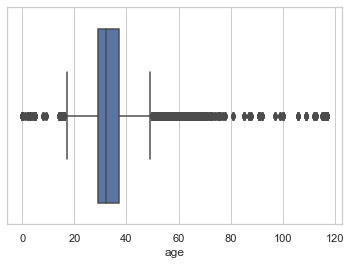

In [19]:
sns.boxplot(x=cloth["age"])

<AxesSubplot:xlabel='height'>

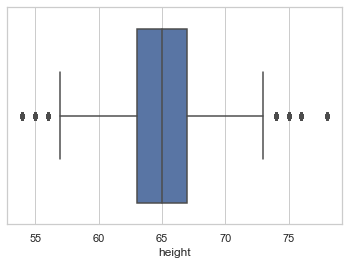

In [20]:
sns.boxplot(x=cloth["height"])

<AxesSubplot:xlabel='weight'>

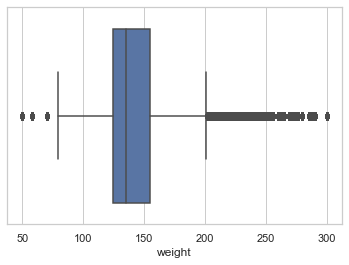

In [21]:
sns.boxplot(x=cloth["weight"])

## Feature Engineering

In [22]:
data = cloth.to_dict('index')

In [23]:
itemsPerUser = defaultdict(set)
usersPerItem = defaultdict(set)
bustPerUser = defaultdict(set)
bustPerItem = defaultdict(set)
weightPerUser = defaultdict(set)
weightPerItem = defaultdict(set)
bodyPerUser = defaultdict(set)
bodyPerItem = defaultdict(set)
heightPerUser = defaultdict(set)
heightPerItem = defaultdict(set)
agePerUser = defaultdict(set)
agePerItem = defaultdict(set)
sizePerUser = defaultdict(set)
sizePerItem = defaultdict(set)
statsPerItem = defaultdict(set)

In [24]:
for k, v in data.items():
    user = v['user_id']
    item = v['item_id']
    bust = v['bust size']
    weight = v['weight']
    body = v['body type']
    height = v['height']
    age = v['age']
    size = v['size']
    
    itemsPerUser[user].add(item)
    usersPerItem[item].add(user)
    bustPerUser[user].add(bust)
    bustPerItem[item].add(bust)
    weightPerUser[user].add(weight)
    weightPerItem[item].add(weight)
    bodyPerUser[user].add(body)
    bodyPerItem[item].add(body)
    heightPerUser[user].add(height)
    heightPerItem[item].add(height)
    agePerUser[user].add(age)
    agePerItem[item].add(age)
    sizePerUser[user].add(size)
    sizePerItem[item].add(size)
    statsPerItem[item].add((height, weight, size))

In [25]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

def CosineSet(s1, s2):
    # Not a proper implementation, operates on sets so correct for interactions only
    numer = len(s1.intersection(s2))
    denom = math.sqrt(len(s1)) * math.sqrt(len(s2))
    if denom == 0:
        return 0
    return numer / denom

def similar_sizes(x, y):
    same = x.intersection(y)
    return random.sample(same, 1)[0]

def avg_item_size(x):
    return sum(list(sizePerItem[x])) / len(list(sizePerItem[x]))

def size_finder(item, y, x):
    possible_sizes = set()

    for d in statsPerItem[item]:
        h = d[0]
        w = d[1]
        s = d[-1]
    
        if h == x:
            possible_sizes.add(s)
        if w in range(y - 3, y + 3, 1):
            possible_sizes.add(s)
            
    return random.sample(possible_sizes, 1)[0]

In [26]:
cloth.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68,14,28,"April 20, 2016"
1,fit,273551,34b,153475,132,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66,12,36,"June 18, 2013"
2,fit,360448,34d,1063761,103,10,party,This hugged in all the right places! It was a ...,apple,It was a great time to celebrate the (almost) ...,sheath,64,4,116,"December 14, 2015"
3,fit,909926,34c,126335,135,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65,8,34,"February 12, 2014"
4,fit,151944,34b,616682,145,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69,12,27,"September 26, 2016"


In [27]:
cloth['user sizes'] = cloth['user_id'].copy().apply(lambda x: sizePerUser[x])
cloth['item sizes'] = cloth['item_id'].copy().apply(lambda x: sizePerItem[x])

In [28]:
cloth['jaccard'] = cloth.apply(lambda x: Jaccard(x['user sizes'], x['item sizes']), axis = 1)

In [29]:
cloth['cosine'] = cloth.apply(lambda x: CosineSet(x['user sizes'], x['item sizes']), axis = 1)

In [30]:
cloth['sim size'] = cloth.apply(lambda x: similar_sizes(x['user sizes'], x['item sizes']), axis = 1)

<ipython-input-25-3f31fbd4c6ef>:18: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  return random.sample(same, 1)[0]


In [31]:
cloth['avg item size'] = cloth['item_id'].apply(avg_item_size)

In [32]:
cloth['pos size'] = cloth.apply(lambda x: size_finder(x['item_id'], x['weight'], x['height']), axis = 1)

<ipython-input-25-3f31fbd4c6ef>:36: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  return random.sample(possible_sizes, 1)[0]


## Models

#### Baseline Model Linear Regression

In [33]:
X = cloth[['weight', 'height']]
y = cloth[['size']]

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [35]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(X_train, y_train)

LinearRegression()

In [36]:
pred = clf.predict(X_test)

In [37]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, pred)

51.539621273510676

In [38]:
clf.score(X_test, y_test)

0.2838804342860569

#### Baseline Model Linear Regression with OHE and additional features

In [39]:
X = cloth[['fit', 'bust size', 'weight', 'rating', 'rented for', 'body type', 'category', 'height', 'age']]
y = cloth[['size']]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
preproc = ColumnTransformer([('fit', OneHotEncoder(handle_unknown = 'ignore'), ['fit']), 
                             ('bust size', OneHotEncoder(handle_unknown = 'ignore'), ['bust size']),
                             ('rented for', OneHotEncoder(handle_unknown = 'ignore'), ['rented for']),
                             ('body type', OneHotEncoder(handle_unknown = 'ignore'), ['body type']),
                             ('category', OneHotEncoder(handle_unknown = 'ignore'), ['category'])
                            ], remainder = 'passthrough')

In [41]:
pl = Pipeline(steps = [('preproc', preproc), ('model', LinearRegression())])

In [42]:
pl.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('fit',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['fit']),
                                                 ('bust size',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['bust size']),
                                                 ('rented for',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['rented for']),
                                                 ('body type',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['body type']),
                                              

In [43]:
pl.score(X_test, y_test)

0.5376372082553698

In [44]:
pred = pl.predict(X_test)
mean_squared_error(y_test, pred)

33.12864805982378

#### Desicion Tree Regressor

In [254]:
from sklearn import tree
dcr = Pipeline(steps = [('preproc', preproc), ('model', tree.DecisionTreeRegressor())])

In [255]:
dcr.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('fit',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['fit']),
                                                 ('bust size',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['bust size']),
                                                 ('rented for',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['rented for']),
                                                 ('body type',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['body type']),
                                              

In [256]:
dcr.score(X_test, y_test)

0.3411956480560818

#### Ridge 

In [289]:
from sklearn import linear_model
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
br = Pipeline(steps = [('preproc', preproc), ('model', Ridge(1))])

In [290]:
br.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('fit',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['fit']),
                                                 ('bust size',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['bust size']),
                                                 ('rented for',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['rented for']),
                                                 ('body type',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['body type']),
                                              

In [291]:
br.score(X_test, y_test)

0.5239960067257012

#### Linear Regression with Jaccard, CosineSet

In [98]:
X = cloth[['fit', 'bust size', 'weight', 'rating', 'rented for', 'body type', 'category', 'height', 'age', 'jaccard', 'cosine']]
y = cloth[['size']]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [99]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
preproc = ColumnTransformer([('fit', OneHotEncoder(handle_unknown = 'ignore'), ['fit']), 
                             ('bust size', OneHotEncoder(handle_unknown = 'ignore'), ['bust size']),
                             ('rented for', OneHotEncoder(handle_unknown = 'ignore'), ['rented for']),
                             ('body type', OneHotEncoder(handle_unknown = 'ignore'), ['body type']),
                             ('category', OneHotEncoder(handle_unknown = 'ignore'), ['category'])
                            ], remainder = 'passthrough')

In [100]:
pl = Pipeline(steps = [('preproc', preproc), ('model', LinearRegression())])

In [101]:
pl.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('fit',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['fit']),
                                                 ('bust size',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['bust size']),
                                                 ('rented for',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['rented for']),
                                                 ('body type',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['body type']),
                                              

In [102]:
pl.score(X_test, y_test)

0.5395344362843839

In [103]:
pred = pl.predict(X_test)

In [104]:
mean_squared_error(y_test, pred)

32.98617380373574

#### Linear Regression with Avg Item Size & Pos Size

In [192]:
X = cloth[['fit', 'bust size', 'weight', 'rating', 'rented for', 'body type', 'category', 'height', 'age', 'avg item size', 'pos size']]
y = cloth[['size']]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [193]:
preproc = ColumnTransformer([('fit', OneHotEncoder(handle_unknown = 'ignore'), ['fit']), 
                             ('bust size', OneHotEncoder(handle_unknown = 'ignore'), ['bust size']),
                             ('rented for', OneHotEncoder(handle_unknown = 'ignore'), ['rented for']),
                             ('body type', OneHotEncoder(handle_unknown = 'ignore'), ['body type']),
                             ('category', OneHotEncoder(handle_unknown = 'ignore'), ['category'])
                            ], remainder = 'passthrough')

pl = Pipeline(steps = [('preproc', preproc), ('model', LinearRegression())])
pl.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('fit',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['fit']),
                                                 ('bust size',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['bust size']),
                                                 ('rented for',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['rented for']),
                                                 ('body type',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['body type']),
                                              

In [194]:
pl.score(X_test, y_test)

0.5902716951213454

In [195]:
pred = pl.predict(X_test)
mean_squared_error(y_test, pred)

29.37451675535057

#### Decision Tree Regression with Sim Size

In [49]:
X = cloth[['fit', 'bust size', 'weight', 'rating', 'rented for', 'body type', 'category', 'height', 'age', 'sim size']]
y = cloth[['size']]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [197]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
preproc = ColumnTransformer([('fit', OneHotEncoder(handle_unknown = 'ignore'), ['fit']), 
                             ('bust size', OneHotEncoder(handle_unknown = 'ignore'), ['bust size']),
                             ('rented for', OneHotEncoder(handle_unknown = 'ignore'), ['rented for']),
                             ('body type', OneHotEncoder(handle_unknown = 'ignore'), ['body type']),
                             ('category', OneHotEncoder(handle_unknown = 'ignore'), ['category'])
                            ], remainder = 'passthrough')

In [130]:
from sklearn import tree
pl = Pipeline(steps = [('preproc', preproc), ('model', tree.DecisionTreeRegressor())])

In [131]:
pl.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('fit',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['fit']),
                                                 ('bust size',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['bust size']),
                                                 ('rented for',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['rented for']),
                                                 ('body type',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['body type']),
                                              

In [132]:
pl.score(X_test, y_test)

0.8518408435020278

In [133]:
pred = pl.predict(X_test)
mean_squared_error(y_test, pred)

10.779136322316294

#### Linear Regression with Sim Size

In [50]:
pl = Pipeline(steps = [('preproc', preproc), ('model', LinearRegression())])
pl.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('fit',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['fit']),
                                                 ('bust size',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['bust size']),
                                                 ('rented for',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['rented for']),
                                                 ('body type',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['body type']),
                                              

In [51]:
pl.score(X_test, y_test)

0.9084038462752729

In [52]:
pred = pl.predict(X_test)
mean_squared_error(y_test, pred)

6.5479849687160145

In [53]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
cross_val_score(pl, X_test, y_test, cv = 5)

array([0.91216759, 0.9098931 , 0.90701437, 0.90563265, 0.90554917])